# Neural Collaborative Filtering

In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [24]:
# Importem data dels ratings de fitxer
file_data = pd.read_csv('../data/ratings.csv')
df = file_data

In [25]:
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [26]:
# Filtrem per obtenir menys pel·licules. Esborrarem les pel·licules que ha vist menys usuaris i els usuaris que han vist menys pel·licules.
user_counts = df['userId'].value_counts()
movie_counts = df['movieId'].value_counts()

# Ens quedem amb les pel·licules vistes per més de 10 usuaris i els usuaris que han vist més de 100 pel·licules
filtered_users = user_counts[user_counts >= 1000].index
filtered_movies = movie_counts[movie_counts >= 10000].index

# Ens assegurem de deixar només les interaccions que tenen pel·lícules que no hem esborrat i els usuaris que no hem esborrat
final_df = df[df['userId'].isin(filtered_users) & df['movieId'].isin(filtered_movies)]

#top_2000_movies = filtered_df['movieId'].value_counts().head(2000).index
#final_df = filtered_df[filtered_df['movieId'].isin(top_2000_movies)]

print(final_df.shape)

(985664, 4)


In [27]:
from sklearn.model_selection import train_test_split

# Separem els ratings en train i test.
train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)
data = {'train': pd.DataFrame(train_data, columns=final_df.columns), 'test': pd.DataFrame(test_data, columns=final_df.columns)}

print("Train Matrix Shape:", data['train'].shape)
print("Test Matrix Shape:", data['test'].shape)

Train Matrix Shape: (788531, 4)
Test Matrix Shape: (197133, 4)


In [28]:
# Com que volem un classificador binari, dividirem les pel·licules en agradat (1) i no agradat (0). Considerem que una pel·lícula ha agradat si té un rating major a 3.
for dataset in ["test", "train"]:
    data[dataset]["interaction"] = data[dataset]['rating'].apply(lambda x: 1 if x > 3 else 0)
    data[dataset] = data[dataset].drop(columns=["rating","timestamp"])

print(data["train"].head())

          userId  movieId  interaction
14625068   94650     5902            1
23674551  153735      151            0
15978512  103598    51255            1
22396649  145626     1641            1
2632625    17507     1210            1


In [29]:
df_train = data["train"]
df_test = data["test"]

print(df_train.shape)
print(df_test.shape)

(788531, 3)
(197133, 3)


In [30]:
# Ens quedarem només amb les interaccions positives, considerant les negatives com a no vistes.
df_train[df_train["interaction"] > 0].head()

,userId,movieId,interaction
14625068,94650,5902,1
15978512,103598,51255,1
22396649,145626,1641,1
2632625,17507,1210,1
21291023,138377,3911,1


In [31]:
# Declarem el nostre model de Collaborative Filtering
import torch
import torch.nn as nn

class NeuralCollaborativeFiltering(nn.Module):
    def __init__(
        self,
        number_of_users,
        number_of_items,
        latent_dim_mf=4,
        latent_dim_mlp=50,
    ):
        super(NeuralCollaborativeFiltering, self).__init__()

        # Nombre de capes FC que tindrà el model després dels embeddings. 
        fully_connected = [32, 16]
        
        # Definim els embeddings
        self.mf_user_embedding = nn.Embedding(num_embeddings=number_of_users,embedding_dim=latent_dim_mf)
        self.mf_item_embedding = nn.Embedding(num_embeddings=number_of_items,embedding_dim=latent_dim_mf)
        self.mlp_user_embedding = nn.Embedding(num_embeddings=number_of_users,embedding_dim=latent_dim_mlp)
        self.mlp_item_embedding = nn.Embedding(num_embeddings=number_of_items,embedding_dim=latent_dim_mlp)

        # Instanciem les fully connected layers que utilitzarem
        self.fully_connected = nn.ModuleList()
        # L'input inicial de la FC serà 2*latent_dim_mlp perquè serà la concatenació de users i items.
        input_size = 2 * latent_dim_mlp
        
        for i, layer_size in enumerate(fully_connected):
            self.fully_connected.append(nn.Linear(input_size, layer_size))
            # L'input de la següent capa serà l'output de l'actual
            input_size = layer_size
        
        # El resultat tindrà una mida d'entrada igual a la mida de la concatenació de la factorització de matrius i la última capa fully connected. 
        self.result = nn.Linear(latent_dim_mf + fully_connected[-1], 1)

        # La funció d'activació de les FC serà ReLU
        self.activation = nn.ReLU()

    def forward(self, user_data, item_data):

        # Creem els embeddings i els multipliquem per obtenir la factorització de matrius.
        mf_user_embedding = self.mf_user_embedding(user_data)
        mf_item_embedding = self.mf_item_embedding(item_data)
        mf_cat_embedding = torch.mul(mf_user_embedding, mf_item_embedding)

        # Creem els embeddings i els concatenem per utilitzar-los al mlp.
        mlp_user_embedding = self.mlp_user_embedding(user_data)
        mlp_item_embedding = self.mlp_item_embedding(item_data)
        mlp_cat_embedding = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=-1)
        
        mlp_vector = mlp_cat_embedding

        # Fem passar l'mlp per totes les capes definides.
        for layer in self.fully_connected:
            mlp_vector = self.activation(layer(mlp_vector))

        # Finalment concatenem els resultats del mlp i la factorització i ho fem passar per la última capa i activació, que serà sigmoide.
        predict_layer = torch.cat([mlp_vector,mf_cat_embedding], dim=-1)
        
        output = torch.sigmoid(self.result(predict_layer))
        
        return output.squeeze()


In [32]:
# Utilitzarem Adam
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Els resultats s'han obtingut amb cuda.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_users = df_train["userId"].shape[0]
n_items = df_train["movieId"].shape[0]

model = NeuralCollaborativeFiltering(number_of_users=n_users, number_of_items=n_items).to(device)
# Comptem els paràmetres que tindrà el model.
print(sum(p.numel() for p in model.parameters()))

85165129


In [33]:
# Utilitzarem el BCELoss com a funció de pèrdua ja que entrenem un classificador binari.
loss_function = nn.BCELoss()
# L'optimitzador serà l'Adam (descens de gradient)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [34]:
# Hem de definir un DataSet especial per passar al dataloader perquè ens interessa que ens retorni tripletes com a getitem, i que accepti els 3 tensors d'entrada.
class CollaborativeFilteringDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        super(Dataset)
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor
        
    def __len__(self):
        return self.user_tensor.size(0)

    def __getitem__(self, idx):
        return self.user_tensor[idx], self.item_tensor[idx], self.target_tensor[idx]

In [35]:
# Instanciem els datasets, passant-los els tres tensors de longs.
train_dataset = CollaborativeFilteringDataset(user_tensor=torch.LongTensor(df_train["userId"].values),
                                              item_tensor=torch.LongTensor(df_train["movieId"].values),
                                              target_tensor=torch.LongTensor(df_train["interaction"].values))
test_dataset = CollaborativeFilteringDataset(user_tensor=torch.LongTensor(df_test["userId"].values),
                                              item_tensor=torch.LongTensor(df_test["movieId"].values),
                                              target_tensor=torch.LongTensor(df_test["interaction"].values))

training_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True)

In [36]:
%%time

epochs = 100

model.train()

training_loss_per_epoch, train_accuracy_per_epoch = [], []
for epoch in range(epochs):
    
    # Per cada epoch posem a 0 el comptador de loss, correctes i totals.
    training_loss = 0
    correct = 0
    total = 0
    
    # Utilitzarem tqdm per embellir l'output
    for batch_id, batch in enumerate(tqdm(training_loader, total=len(training_loader), desc=f"Epoch {epoch}/{epochs}")):
        
        # Obtenim del DataLoader les dades del batch actual.
        user, item, interaction = batch[0], batch[1], batch[2]
        
        # Els enviem tots a cuda si cal i passem la interacció a float per poder ser comparada amb la predicció
        user = user.to(device)
        item = item.to(device)
        interaction = interaction.to(device).float()
        
        # Predim l'output actual
        optimizer.zero_grad()
        predict = model(user,item).to(device)
        
        # Calculem la pèrdua i cridem loss.backward i l'optimitzador per tal que aprenguin.
        loss = loss_function(predict.view(-1), interaction)
        loss.backward()
        optimizer.step()
        
        # Finalment incrementem els comptadors.
        training_loss += loss.item()
           
        correct += (torch.round(predict).to(torch.long) == interaction).sum().item()
        total += len(interaction)
    
    accuracy = correct/total*100
    training_loss_per_epoch.append(training_loss)
    train_accuracy_per_epoch.append(accuracy)
    print('training loss: {:.3f}, training accuracy: {:.2f}%'.format(training_loss, accuracy))

Epoch 0/100: 100%|██████████| 97/97 [00:10<00:00,  9.39it/s]


training loss: 63.862, training accuracy: 61.52%


Epoch 1/100: 100%|██████████| 97/97 [00:10<00:00,  9.37it/s]


training loss: 61.685, training accuracy: 63.75%


Epoch 2/100: 100%|██████████| 97/97 [00:09<00:00,  9.81it/s]


training loss: 59.377, training accuracy: 67.04%


Epoch 3/100: 100%|██████████| 97/97 [00:09<00:00,  9.76it/s]


training loss: 57.948, training accuracy: 69.02%


Epoch 4/100: 100%|██████████| 97/97 [00:10<00:00,  9.25it/s]


training loss: 57.330, training accuracy: 69.45%


Epoch 5/100: 100%|██████████| 97/97 [00:10<00:00,  9.10it/s]


training loss: 56.961, training accuracy: 69.68%


Epoch 6/100: 100%|██████████| 97/97 [00:10<00:00,  8.99it/s]


training loss: 56.688, training accuracy: 69.89%


Epoch 7/100: 100%|██████████| 97/97 [00:10<00:00,  9.48it/s]


training loss: 56.442, training accuracy: 70.06%


Epoch 8/100: 100%|██████████| 97/97 [00:10<00:00,  9.69it/s]


training loss: 56.204, training accuracy: 70.25%


Epoch 9/100: 100%|██████████| 97/97 [00:09<00:00,  9.77it/s]


training loss: 55.925, training accuracy: 70.45%


Epoch 10/100: 100%|██████████| 97/97 [00:10<00:00,  9.67it/s]


training loss: 55.642, training accuracy: 70.65%


Epoch 11/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


training loss: 55.317, training accuracy: 70.87%


Epoch 12/100: 100%|██████████| 97/97 [00:10<00:00,  9.41it/s]


training loss: 54.963, training accuracy: 71.18%


Epoch 13/100: 100%|██████████| 97/97 [00:10<00:00,  9.60it/s]


training loss: 54.535, training accuracy: 71.47%


Epoch 14/100: 100%|██████████| 97/97 [00:09<00:00,  9.83it/s]


training loss: 54.024, training accuracy: 71.85%


Epoch 15/100: 100%|██████████| 97/97 [00:09<00:00,  9.81it/s]


training loss: 53.453, training accuracy: 72.31%


Epoch 16/100: 100%|██████████| 97/97 [00:10<00:00,  9.50it/s]


training loss: 52.834, training accuracy: 72.78%


Epoch 17/100: 100%|██████████| 97/97 [00:10<00:00,  9.55it/s]


training loss: 52.260, training accuracy: 73.22%


Epoch 18/100: 100%|██████████| 97/97 [00:09<00:00,  9.82it/s]


training loss: 51.768, training accuracy: 73.57%


Epoch 19/100: 100%|██████████| 97/97 [00:09<00:00,  9.81it/s]


training loss: 51.356, training accuracy: 73.86%


Epoch 20/100: 100%|██████████| 97/97 [00:10<00:00,  9.33it/s]


training loss: 51.040, training accuracy: 74.05%


Epoch 21/100: 100%|██████████| 97/97 [00:10<00:00,  9.45it/s]


training loss: 50.848, training accuracy: 74.20%


Epoch 22/100: 100%|██████████| 97/97 [00:10<00:00,  9.53it/s]


training loss: 50.679, training accuracy: 74.26%


Epoch 23/100: 100%|██████████| 97/97 [00:10<00:00,  9.42it/s]


training loss: 50.568, training accuracy: 74.37%


Epoch 24/100: 100%|██████████| 97/97 [00:10<00:00,  9.14it/s]


training loss: 50.492, training accuracy: 74.41%


Epoch 25/100: 100%|██████████| 97/97 [00:09<00:00,  9.79it/s]


training loss: 50.409, training accuracy: 74.44%


Epoch 26/100: 100%|██████████| 97/97 [00:09<00:00,  9.78it/s]


training loss: 50.355, training accuracy: 74.49%


Epoch 27/100: 100%|██████████| 97/97 [00:09<00:00,  9.91it/s]


training loss: 50.304, training accuracy: 74.49%


Epoch 28/100: 100%|██████████| 97/97 [00:10<00:00,  9.64it/s]


training loss: 50.262, training accuracy: 74.52%


Epoch 29/100: 100%|██████████| 97/97 [00:10<00:00,  9.62it/s]


training loss: 50.168, training accuracy: 74.60%


Epoch 30/100: 100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


training loss: 50.116, training accuracy: 74.62%


Epoch 31/100: 100%|██████████| 97/97 [00:09<00:00,  9.71it/s]


training loss: 50.043, training accuracy: 74.65%


Epoch 32/100: 100%|██████████| 97/97 [00:10<00:00,  9.63it/s]


training loss: 49.972, training accuracy: 74.67%


Epoch 33/100: 100%|██████████| 97/97 [00:10<00:00,  9.36it/s]


training loss: 49.861, training accuracy: 74.70%


Epoch 34/100: 100%|██████████| 97/97 [00:10<00:00,  9.41it/s]


training loss: 49.790, training accuracy: 74.76%


Epoch 35/100: 100%|██████████| 97/97 [00:10<00:00,  9.58it/s]


training loss: 49.657, training accuracy: 74.79%


Epoch 36/100: 100%|██████████| 97/97 [00:10<00:00,  9.47it/s]


training loss: 49.493, training accuracy: 74.89%


Epoch 37/100: 100%|██████████| 97/97 [00:10<00:00,  9.44it/s]


training loss: 49.309, training accuracy: 74.98%


Epoch 38/100: 100%|██████████| 97/97 [00:09<00:00,  9.71it/s]


training loss: 49.096, training accuracy: 75.06%


Epoch 39/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


training loss: 48.880, training accuracy: 75.17%


Epoch 40/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


training loss: 48.622, training accuracy: 75.30%


Epoch 41/100: 100%|██████████| 97/97 [00:10<00:00,  9.02it/s]


training loss: 48.457, training accuracy: 75.38%


Epoch 42/100: 100%|██████████| 97/97 [00:10<00:00,  9.50it/s]


training loss: 48.370, training accuracy: 75.42%


Epoch 43/100: 100%|██████████| 97/97 [00:09<00:00,  9.90it/s]


training loss: 48.278, training accuracy: 75.52%


Epoch 44/100: 100%|██████████| 97/97 [00:10<00:00,  9.54it/s]


training loss: 48.208, training accuracy: 75.55%


Epoch 45/100: 100%|██████████| 97/97 [00:10<00:00,  9.40it/s]


training loss: 48.159, training accuracy: 75.57%


Epoch 46/100: 100%|██████████| 97/97 [00:10<00:00,  9.59it/s]


training loss: 48.096, training accuracy: 75.66%


Epoch 47/100: 100%|██████████| 97/97 [00:10<00:00,  9.58it/s]


training loss: 48.061, training accuracy: 75.68%


Epoch 48/100: 100%|██████████| 97/97 [00:10<00:00,  9.51it/s]


training loss: 48.018, training accuracy: 75.72%


Epoch 49/100: 100%|██████████| 97/97 [00:10<00:00,  9.43it/s]


training loss: 47.973, training accuracy: 75.73%


Epoch 50/100: 100%|██████████| 97/97 [00:09<00:00,  9.81it/s]


training loss: 47.953, training accuracy: 75.75%


Epoch 51/100: 100%|██████████| 97/97 [00:09<00:00,  9.79it/s]


training loss: 47.906, training accuracy: 75.80%


Epoch 52/100: 100%|██████████| 97/97 [00:10<00:00,  9.33it/s]


training loss: 47.867, training accuracy: 75.79%


Epoch 53/100: 100%|██████████| 97/97 [00:10<00:00,  9.62it/s]


training loss: 47.827, training accuracy: 75.84%


Epoch 54/100: 100%|██████████| 97/97 [00:10<00:00,  9.67it/s]


training loss: 47.820, training accuracy: 75.82%


Epoch 55/100: 100%|██████████| 97/97 [00:09<00:00,  9.72it/s]


training loss: 47.777, training accuracy: 75.86%


Epoch 56/100: 100%|██████████| 97/97 [00:10<00:00,  9.40it/s]


training loss: 47.743, training accuracy: 75.86%


Epoch 57/100: 100%|██████████| 97/97 [00:10<00:00,  9.51it/s]


training loss: 47.723, training accuracy: 75.90%


Epoch 58/100: 100%|██████████| 97/97 [00:09<00:00,  9.70it/s]


training loss: 47.704, training accuracy: 75.90%


Epoch 59/100: 100%|██████████| 97/97 [00:10<00:00,  9.67it/s]


training loss: 47.670, training accuracy: 75.94%


Epoch 60/100: 100%|██████████| 97/97 [00:10<00:00,  9.63it/s]


training loss: 47.662, training accuracy: 75.92%


Epoch 61/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


training loss: 47.629, training accuracy: 75.95%


Epoch 62/100: 100%|██████████| 97/97 [00:10<00:00,  9.48it/s]


training loss: 47.604, training accuracy: 75.97%


Epoch 63/100: 100%|██████████| 97/97 [00:10<00:00,  9.55it/s]


training loss: 47.585, training accuracy: 75.94%


Epoch 64/100: 100%|██████████| 97/97 [00:10<00:00,  9.64it/s]


training loss: 47.578, training accuracy: 75.99%


Epoch 65/100: 100%|██████████| 97/97 [00:09<00:00,  9.75it/s]


training loss: 47.567, training accuracy: 75.97%


Epoch 66/100: 100%|██████████| 97/97 [00:10<00:00,  9.37it/s]


training loss: 47.547, training accuracy: 75.99%


Epoch 67/100: 100%|██████████| 97/97 [00:10<00:00,  9.54it/s]


training loss: 47.535, training accuracy: 76.01%


Epoch 68/100: 100%|██████████| 97/97 [00:10<00:00,  9.30it/s]


training loss: 47.508, training accuracy: 76.02%


Epoch 69/100: 100%|██████████| 97/97 [00:10<00:00,  9.47it/s]


training loss: 47.496, training accuracy: 76.02%


Epoch 70/100: 100%|██████████| 97/97 [00:10<00:00,  9.60it/s]


training loss: 47.468, training accuracy: 76.06%


Epoch 71/100: 100%|██████████| 97/97 [00:10<00:00,  9.26it/s]


training loss: 47.482, training accuracy: 76.05%


Epoch 72/100: 100%|██████████| 97/97 [00:10<00:00,  9.47it/s]


training loss: 47.460, training accuracy: 76.07%


Epoch 73/100: 100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


training loss: 47.429, training accuracy: 76.05%


Epoch 74/100: 100%|██████████| 97/97 [00:10<00:00,  9.57it/s]


training loss: 47.423, training accuracy: 76.09%


Epoch 75/100: 100%|██████████| 97/97 [00:09<00:00,  9.78it/s]


training loss: 47.394, training accuracy: 76.10%


Epoch 76/100: 100%|██████████| 97/97 [00:10<00:00,  9.28it/s]


training loss: 47.389, training accuracy: 76.09%


Epoch 77/100: 100%|██████████| 97/97 [00:10<00:00,  9.38it/s]


training loss: 47.364, training accuracy: 76.07%


Epoch 78/100: 100%|██████████| 97/97 [00:10<00:00,  9.37it/s]


training loss: 47.360, training accuracy: 76.11%


Epoch 79/100: 100%|██████████| 97/97 [00:09<00:00,  9.82it/s]


training loss: 47.373, training accuracy: 76.11%


Epoch 80/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


training loss: 47.372, training accuracy: 76.11%


Epoch 81/100: 100%|██████████| 97/97 [00:10<00:00,  9.34it/s]


training loss: 47.338, training accuracy: 76.14%


Epoch 82/100: 100%|██████████| 97/97 [00:10<00:00,  9.70it/s]


training loss: 47.314, training accuracy: 76.13%


Epoch 83/100: 100%|██████████| 97/97 [00:10<00:00,  9.36it/s]


training loss: 47.329, training accuracy: 76.11%


Epoch 84/100: 100%|██████████| 97/97 [00:10<00:00,  9.59it/s]


training loss: 47.304, training accuracy: 76.12%


Epoch 85/100: 100%|██████████| 97/97 [00:10<00:00,  9.52it/s]


training loss: 47.290, training accuracy: 76.12%


Epoch 86/100: 100%|██████████| 97/97 [00:10<00:00,  9.33it/s]


training loss: 47.289, training accuracy: 76.14%


Epoch 87/100: 100%|██████████| 97/97 [00:10<00:00,  9.10it/s]


training loss: 47.295, training accuracy: 76.16%


Epoch 88/100: 100%|██████████| 97/97 [00:10<00:00,  9.23it/s]


training loss: 47.258, training accuracy: 76.16%


Epoch 89/100: 100%|██████████| 97/97 [00:10<00:00,  9.28it/s]


training loss: 47.258, training accuracy: 76.21%


Epoch 90/100: 100%|██████████| 97/97 [00:10<00:00,  9.59it/s]


training loss: 47.257, training accuracy: 76.18%


Epoch 91/100: 100%|██████████| 97/97 [00:10<00:00,  9.29it/s]


training loss: 47.243, training accuracy: 76.19%


Epoch 92/100: 100%|██████████| 97/97 [00:09<00:00,  9.93it/s]


training loss: 47.222, training accuracy: 76.21%


Epoch 93/100: 100%|██████████| 97/97 [00:10<00:00,  9.69it/s]


training loss: 47.225, training accuracy: 76.23%


Epoch 94/100: 100%|██████████| 97/97 [00:10<00:00,  9.03it/s]


training loss: 47.211, training accuracy: 76.22%


Epoch 95/100: 100%|██████████| 97/97 [00:10<00:00,  9.53it/s]


training loss: 47.222, training accuracy: 76.23%


Epoch 96/100: 100%|██████████| 97/97 [00:10<00:00,  9.27it/s]


training loss: 47.191, training accuracy: 76.21%


Epoch 97/100: 100%|██████████| 97/97 [00:10<00:00,  9.55it/s]


training loss: 47.192, training accuracy: 76.23%


Epoch 98/100: 100%|██████████| 97/97 [00:10<00:00,  9.29it/s]


training loss: 47.165, training accuracy: 76.22%


Epoch 99/100: 100%|██████████| 97/97 [00:10<00:00,  9.56it/s]

training loss: 47.170, training accuracy: 76.27%
CPU times: total: 5min 29s
Wall time: 16min 59s


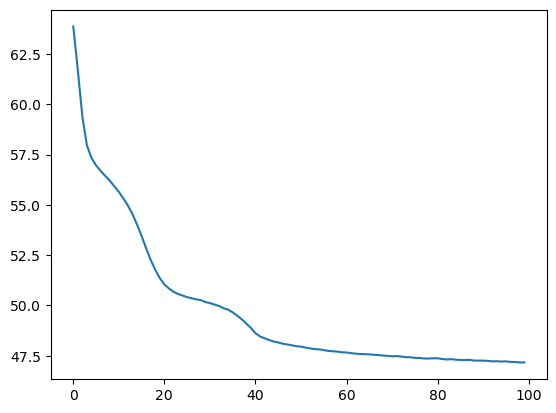

In [37]:
import matplotlib.pyplot as plt
# Mostrem per pantalla l'evolució del training loss.
plt.plot(training_loss_per_epoch)

plt.show()

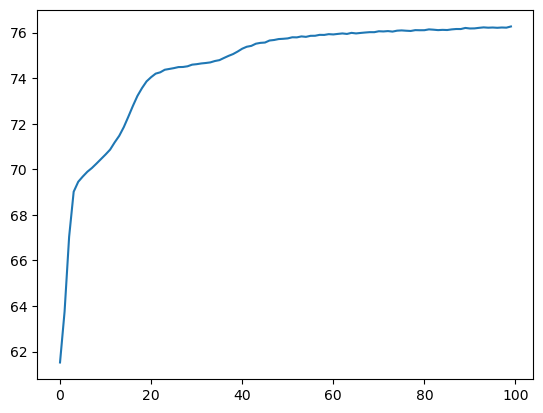

In [38]:
# Mostrem per pantalla l'evolució de l'accuracy a train.
plt.plot(train_accuracy_per_epoch)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [40]:
# Una vegada entrenat el model, fem les prediccions amb test.
def test_predict(model, test_loader):
    model.eval()

    cor = 0
    tot = 0
    predictions = []
    targets = []
    elements = []

    with torch.no_grad():
        for user_data, item_data, interaction_data in test_loader:
            user_data = user_data.to(device)
            item_data = item_data.to(device)
            interaction_data = interaction_data.to(device)
            pred = model(user_data, item_data).to(device)  # Forward pass

            predictions.extend(pred.flatten().tolist())
            targets.extend(interaction_data.flatten().tolist())
            
            # Calcularem les prediccions i les empaquetarem per cada usuari i pel·licula, per després poder extreure'n més info.
            for i in range(len(user_data)):
                uid = user_data[i].item()
                iid = item_data[i].item()
                true_r = interaction_data[i].item()
                est = pred[i].item()
                elements.append((uid, iid, true_r, est))
            
            cor += (torch.round(pred.flatten()).to(torch.long) == interaction_data.flatten()).sum().item()
            tot += len(user_data)
        
        # Mostrem les mètriques de test.
        test_accuracy = cor/tot
        print("Test accuracy: {:.4f}%".format(test_accuracy))
        print("Test MSE: %0.3f" % mean_squared_error(predictions, targets))
        print("Test MAE: %0.3f" % mean_absolute_error(predictions, targets))

    return elements

elements = test_predict(model, test_loader)

Test accuracy: 0.7584%
Test MSE: 0.163
Test MAE: 0.330


In [41]:
from collections import defaultdict

# Fució que ens permetrà obtenir les 10 prediccions amb més probabilitat d'interacció de tots els usuaris.
def get_top_n(predictions, n=10):
    # Instanciem el diccionari d'usuaris
    top_n = defaultdict(list)
    
    # Afegim al diccionari totes les prediccions.
    for uid, iid, true_r, est in predictions:
        top_n[uid].append((iid, est))
    
    # Ordenem per probabilitat d'interacció i ens quedem amb els n primers.
    for uid, interaction_prob in top_n.items():
        interaction_prob.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = interaction_prob[:n]
    
    # Retornem els n primers.
    return top_n

In [42]:
# Llegirem els noms de les pel·lícules per poder mostrar un exemple de prediccions.
movie_data = pd.read_csv('../data/movies.csv')

In [52]:
# Nombre de prediccions que volem per cada usuari
N = 5

# Aconseguim les topn prediccions per cada usuari.
top_n = get_top_n(elements, n=N)

# Per cada usuari entre els que vulguem, mostrarem els 5 elements amb més rating i les 5 pel·licules recomanades.
# No està pensat per extreure'n conclusions sinó simplement per mostrar visualment el funcionament.
for uid, user_ratings in list(top_n.items())[:2]:
    print("USER: {:.0f}".format(uid))
    ratings = file_data[file_data['userId'] == uid].sort_values(by='rating', ascending=False).head(N)["movieId"].tolist()
    print("Millors notes: " + str([movie_data.loc[movie_data['movieId']==iid,'title'].values[0] for iid in ratings]))
    print("Interaccions: " + str([movie_data.loc[movie_data['movieId']==iid,'title'].values[0] for (iid, _) in user_ratings]) + "\n")

USER: 86930
Millors notes: ['Rush Hour 3 (2007)', 'Crimson Peak (2015)', 'Stepmom (1998)', 'Patch Adams (1998)', 'Bend It Like Beckham (2002)']
Interaccions: ['Sixth Sense, The (1999)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Taken (2008)', 'Bourne Identity, The (2002)', 'Forrest Gump (1994)']

USER: 111073
Millors notes: ['Usual Suspects, The (1995)', 'Prestige, The (2006)', "Adam's Apples (Adams æbler) (2005)", 'Rushmore (1998)', 'American Beauty (1999)']
Interaccions: ['Goodfellas (1990)', 'Eternal Sunshine of the Spotless Mind (2004)', 'No Country for Old Men (2007)', 'Moon (2009)', 'L.A. Confidential (1997)']


In [48]:
# Calculem la precisió i recall at K (entre els K primers) Molt important, ja que com que estem fent un recomanador, no ens interessen les que no recomanarem.
K = 5

def precision_recall_at_k(predictions, k=10, threshold=0.5):
    user_est_true = defaultdict(list)
    # Creem el diccionari de pel·lícules per cada usuari.
    for uid, _, true_int, est in predictions:
        user_est_true[uid].append((est, true_int))
    
    precisions = dict()
    recalls = dict()
    # De cada element del diccionari obtenim id i probabilitat d'interacció.
    for uid, interaction_prob in user_est_true.items():
        # Ordenem per poder trobar els primers K
        interaction_prob.sort(key=lambda x: x[0], reverse=True)
        # Només sumem els que tenen una interacció superior al threshold marcat.
        n_rel = sum((true_int >= threshold) for (_, true_int) in interaction_prob)
        n_rec_k = sum((est >= threshold) for (est, _) in interaction_prob[:k])
        
        # Trobem el nombre d'elements que pertanyen al topk
        n_rel_and_rec_k = sum(((true_int >= threshold) and (est >= threshold)) for (est, true_int) in interaction_prob[:k])
        
        # Precision@k = Nombre de recomanacions rellevants / Nombre de recomanats
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        
        # Recall@k = Nombre de recomanacions rellevants / Nombre d'items rellevants
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel > 0 else 0
    
    return precisions, recalls

precisions, recalls = precision_recall_at_k(elements, k=K, threshold=0.5)

# Calculem la mitjana de precisions per tots els usuaris.
mean_precision = sum(precisions.values()) / len(precisions)
mean_recall = sum(recalls.values()) / len(recalls)

print(f"Mean Precision@{K}: {mean_precision:.4f}")
print(f"Std Precision@{K}: {np.std(np.array(list(precisions.values()))):.4f}")
print(f"Mean Recall@{K}: {mean_recall:.4f}")
print(f"Std Recall@{K}: {np.std(np.array(list(recalls.values()))):.4f}")

Mean Precision@5: 0.8764
Std Precision@5: 0.2018
Mean Recall@5: 0.1032
Std Recall@5: 0.0443
